In [51]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pycaret.classification import *
from pycaret.utils import check_metric
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["font.size"] = 30

DATA = 'data/'

In [52]:
train = pd.read_csv(DATA + 'train_churn.csv', sep=',', encoding='utf-8')
test = pd.read_csv(DATA + 'test_churn.csv', sep=',', encoding='utf-8')
df = pd.read_csv(DATA + 'churn.csv', sep=',', encoding='utf-8')

print(f"Dataset de entrenamiento tiene un shape de {train.shape}. Percentage {(len(train)/len(df)):.2%}%")
print(f"Dataset de prueba tiene un shape de {test.shape}. Percentage {(len(test)/len(df)):.2%}%")
del df

train.info()

Dataset de entrenamiento tiene un shape de (29594, 22). Percentage 80.00%%
Dataset de prueba tiene un shape de (7398, 22). Percentage 20.00%%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29594 entries, 0 to 29593
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   age                           29594 non-null  object
 1   gender                        29594 non-null  object
 2   region_category               29594 non-null  object
 3   membership_category           29594 non-null  object
 4   joining_date                  29594 non-null  object
 5   joined_through_referral       29594 non-null  object
 6   preferred_offer_types         29594 non-null  object
 7   medium_of_operation           29594 non-null  object
 8   internet_option               29594 non-null  object
 9   last_visit_time               29594 non-null  object
 10  days_since_last_login         29594 non-null  in

## Pycaret's setup
This function initializes the training environment and creates the transformation pipeline

In [53]:
exp = setup(data=train, target='churn_risk_score', session_id=10001)

,Description,Value
0,session_id,10001
1,Target,churn_risk_score
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(29594, 22)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


## Models

In [54]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8567,0.9440,0.7870,0.9371,0.8554,0.7155,0.7263,2.6370
svm,SVM - Linear Kernel,0.8524,0.0000,0.7936,0.9237,0.8527,0.7065,0.7160,0.1830
et,Extra Trees Classifier,0.8517,0.9445,0.8437,0.8766,0.8597,0.7025,0.7033,2.0900
ada,Ada Boost Classifier,0.8512,0.9438,0.8454,0.8745,0.8596,0.7015,0.7020,0.6820
lr,Logistic Regression,0.8509,0.9442,0.8359,0.8816,0.8580,0.7013,0.7026,0.9400
rf,Random Forest Classifier,0.8509,0.9442,0.8305,0.8857,0.8572,0.7015,0.7032,1.6070
ridge,Ridge Classifier,0.8496,0.0000,0.7469,0.9664,0.8426,0.7031,0.7246,0.0460
lda,Linear Discriminant Analysis,0.8496,0.9437,0.7468,0.9664,0.8425,0.7030,0.7245,0.5750
lightgbm,Light Gradient Boosting Machine,0.8496,0.9427,0.8343,0.8804,0.8567,0.6987,0.6999,0.2230
nb,Naive Bayes,0.8385,0.8282,1.0000,0.7695,0.8697,0.6667,0.7071,0.0480


Como podemos ver, los mejores algoritmos son:

- **Gradient Boosting Classifier**:
    - El mejor Accuracy (por poco)
    - Tiene también el mejor Area Under Curve Score
    - De los tres es el que mejor Precision Score tiene
- **Random Forest Classifier**
    - Comparte el mejor Area Under Curve Score con el método anterior
    - Además es el que mejor F-1 Score tiene (que se puede interpretar como una media entre La precisión y el Recall)
- **Ada Boost Classifier**
    - Sobre sale por su bajísimo tiempo de entrenamiento

## Best model
Trabajemos un poco sobre el GBC comprendiendo que RF y ADA también podrían haber sido buenísimas primeras aproximaciones

In [55]:
best_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8528,0.9379,0.7885,0.9273,0.8523,0.7075,0.7167
1,0.8576,0.9417,0.7912,0.9344,0.8569,0.7172,0.7270
2,0.8668,0.9526,0.8011,0.9430,0.8663,0.7353,0.7451
3,0.8591,0.9491,0.7905,0.9384,0.8581,0.7202,0.7306
4,0.8557,0.9379,0.7932,0.9287,0.8556,0.7132,0.7220
5,0.8609,0.9472,0.7921,0.9404,0.8599,0.7239,0.7344
6,0.8503,0.9412,0.7742,0.9371,0.8479,0.7032,0.7156
7,0.8503,0.9394,0.7688,0.9429,0.8470,0.7034,0.7175
8,0.8590,0.9453,0.7903,0.9383,0.8580,0.7200,0.7305


In [56]:
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8509,0.9399,0.8047,0.9080,0.8532,0.7028,0.7081
1,0.8518,0.9427,0.7993,0.9149,0.8532,0.7050,0.7116
2,0.8620,0.9492,0.8154,0.9192,0.8642,0.7249,0.7303
3,0.8557,0.9509,0.7932,0.9287,0.8556,0.7132,0.7220
4,0.8523,0.9397,0.7986,0.9168,0.8536,0.7060,0.7129
5,0.8590,0.9522,0.8100,0.9187,0.8610,0.7191,0.7250
6,0.8513,0.9447,0.7948,0.9182,0.8521,0.7041,0.7115
7,0.8474,0.9390,0.7894,0.9158,0.8479,0.6965,0.7043
8,0.8561,0.9447,0.8029,0.9199,0.8574,0.7135,0.7203


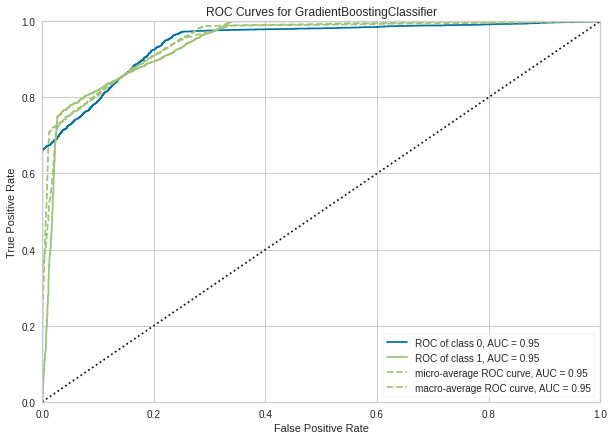

In [57]:
plot_model(tuned_best_model, plot='auc')

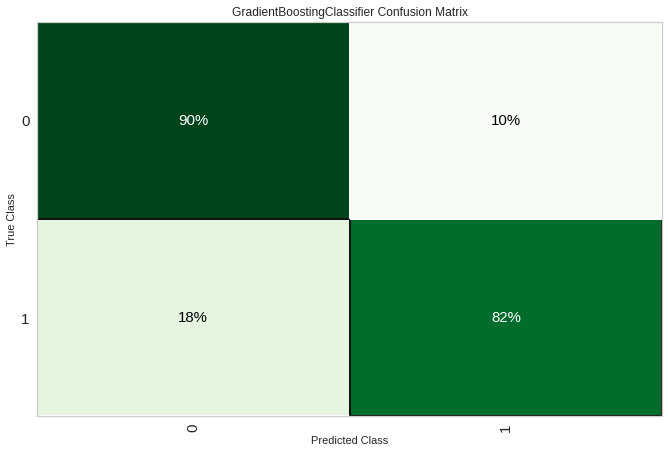

In [58]:
plot_model(tuned_best_model, plot='confusion_matrix', plot_kwargs={'percent' : True})

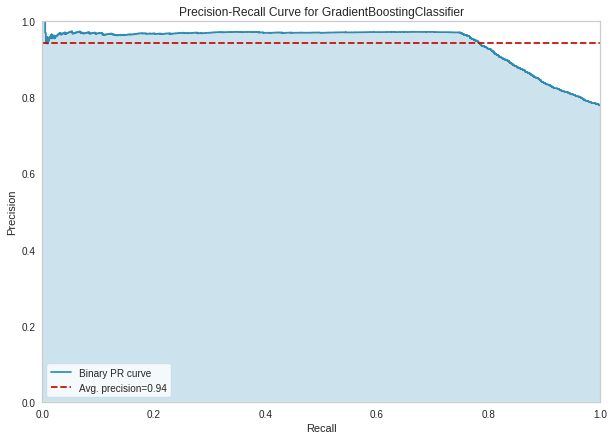

In [59]:
plot_model(tuned_best_model, plot = 'pr')

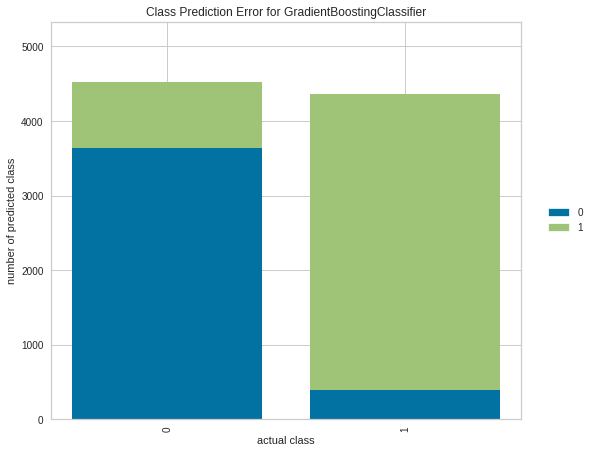

In [60]:
plot_model(tuned_best_model, plot = 'error')

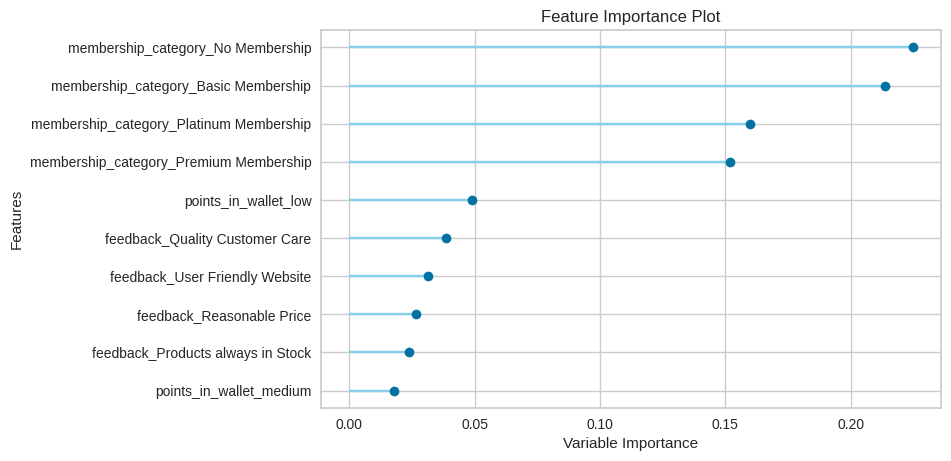

In [61]:
plot_model(tuned_best_model, plot='feature')

Este gráfico es muy interesante porque nos permite obtener una respuesta preliminar sobre algunas de las preguntas que hicimos como kickoff: el tipo de membresía al que pertenece un cliente, sus puntos en _wallet_ y el feedback son importantes a la hora de determinar si corre riesgo de _churn_

## Modelo final
Ahora que ya tenemos el modelo tuneado, entonces finalizamos

In [62]:
model = finalize_model(tuned_best_model)
print(model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=10,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.5, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10001, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## test dataset

In [64]:
res = predict_model(model, data=test)
res.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8523,0.9420,0.8098,0.9071,0.8557,0.7053,0.7101


,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,points_in_wallet,used_special_discount,offer_application_preference,feedback,churn_risk_score,joining_semester,last_time_period,past_complaint_status,Label,Score
0,51-64,M,Unknown,Silver Membership,2017-06-22,Yes,Without Offers,Desktop,Fiber_Optic,1900-01-01 17:23:08,...,medium,No,Yes,Too many ads,0,4,noon,4,0,0.5600
1,24-37,M,Village,No Membership,2016-04-27,Yes,Credit/Debit Card Offers,Both,Mobile_Data,1900-01-01 17:45:55,...,low,No,Yes,Too many ads,1,2,noon,2,1,0.9594
2,24-37,M,City,Premium Membership,2016-05-15,No,Gift Vouchers/Coupons,Desktop,Wi-Fi,1900-01-01 23:33:05,...,low,No,Yes,No reason specified,0,2,noon,4,0,0.9679
3,24-37,F,Town,Gold Membership,2015-11-28,Yes,Credit/Debit Card Offers,Smartphone,Wi-Fi,1900-01-01 21:58:13,...,medium,Yes,No,No reason specified,1,1,noon,4,0,0.5312
4,38-50,F,Unknown,Basic Membership,2017-09-05,Yes,Gift Vouchers/Coupons,Smartphone,Fiber_Optic,1900-01-01 14:04:56,...,medium,Yes,No,Poor Product Quality,1,5,day,4,1,0.9564


In [65]:
for metric in ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1']:
    m = check_metric(res['churn_risk_score'], res['Label'], metric=metric)
    print(f"Score for {metric} is {m:.2f}")

Score for Accuracy is 0.85
Score for AUC is 0.86
Score for Recall is 0.81
Score for Precision is 0.91
Score for F1 is 0.86


In [66]:
save_model(model,'./gbc_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='churn_risk_score',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 num...
                                             learning_rate=0.15, loss='deviance',
                                             max_depth=10, max_features='log2',
                                             max_leaf_nodes=None,
       

/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final

/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/home/nicolas/75-70-tp-final

# Mejoras
 - Algunos plots más antes de Feature Engineering
 - PCA para reducir dimensiones
 - Armar un modelo que sea la composición de los tres mejores modelos
 - Un poco más de Ingeniería del Conocimiento